In [1]:
include("includes.jl");

### The setup

### Plotting the likelihood

	From worker 5:	<div id="interact-js-shim">
	From worker 5:	    <script charset="utf-8">
	From worker 5:	(function (IPython, $, _, MathJax) {
	From worker 5:	    $.event.special.destroyed = {
	From worker 5:		remove: function(o) {
	From worker 5:		    if (o.handler) {
	From worker 5:			o.handler.apply(this, arguments)
	From worker 5:		    }
	From worker 5:		}
	From worker 5:	    }
	From worker 5:	
	From worker 5:	    var OutputArea = IPython.version >= "4.0.0" ? require("notebook/js/outputarea").OutputArea : IPython.OutputArea;
	From worker 5:	
	From worker 5:	    var redrawValue = function (container, type, val) {
	From worker 5:		var selector = $("<div/>");
	From worker 5:		var oa = new OutputArea(_.extend(selector, {
	From worker 5:		    selector: selector,
	From worker 5:		    prompt_area: true,
	From worker 5:		    events: IPython.events,
	From worker 5:		    keyboard_manager: IPython.keyboard_manager
	From worker 5:		})); // Hack to work with IPython 2.1.0
	From worker 5:	
	From 

	From worker 4:	           }
	From worker 4:	       })
	From worker 4:	       $([IPython.events]).on("kernel_starting.Kernel kernel_restarting.Kernel", function () { window.interactLoadedFlag = false })
	From worker 4:	   </script>
	From worker 3:	<div id="interact-js-shim">
	From worker 3:	    <script charset="utf-8">
	From worker 3:	(function (IPython, $, _, MathJax) {
	From worker 3:	    $.event.special.destroyed = {
	From worker 3:		remove: function(o) {
	From worker 3:		    if (o.handler) {
	From worker 3:			o.handler.apply(this, arguments)
	From worker 3:		    }
	From worker 3:		}
	From worker 3:	    }
	From worker 3:	
	From worker 3:	    var OutputArea = IPython.version >= "4.0.0" ? require("notebook/js/outputarea").OutputArea : IPython.OutputArea;
	From worker 3:	
	From worker 3:	    var redrawValue = function (container, type, val) {
	From worker 3:		var selector = $("<div/>");
	From worker 3:		var oa = new OutputArea(_.extend(selector, {
	From worker 3:		    selector: selecto

Interact.Options{:SelectionSlider,Any}(1: "input" = 6 Any , "n", 6, "6", 6, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…), Dict{Any,Any}(Pair{Any,Any}(2, "2"),Pair{Any,Any}(11, "11"),Pair{Any,Any}(7, "7"),Pair{Any,Any}(9, "9"),Pair{Any,Any}(10, "10"),Pair{Any,Any}(8, "8"),Pair{Any,Any}(6, "6"),Pair{Any,Any}(4, "4"),Pair{Any,Any}(3, "3"),Pair{Any,Any}(5, "5")…)), Any[], Any[], true, "horizontal")

Interact.Options{:SelectionSlider,Any}(3: "input-2" = 29 Any , "kid", 29, "29", 29, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…), Dict{Any,Any}(Pair{Any,Any}(2, "2"),Pair{Any,Any}(11, "11"),Pair{Any,Any}(39, "39"),Pair{Any,Any}(46, "46"),Pair{Any,Any}(25, "25"),Pair{Any,Any}(55, "55"),Pair{Any,Any}(42, "42"),Pair{Any,Any}(29, "29"),Pair{Any,Any}(58, "58"),Pair{Any,Any}(8, "8")…)), Any[], Any[], true, "horizontal")

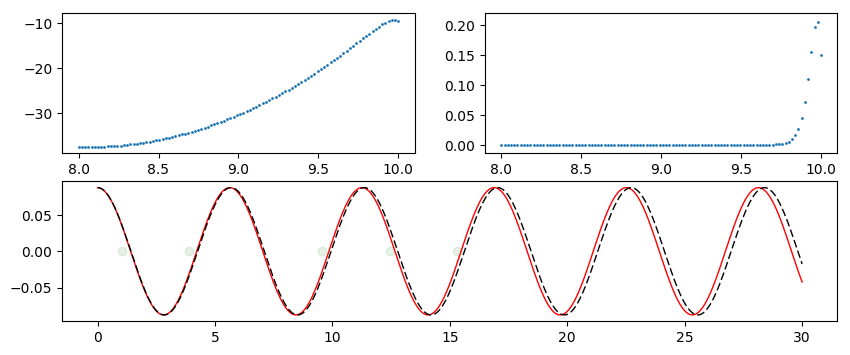

In [2]:
using Interact

measurements, measurements_mask = load_experiments()
n_measurements = size(measurements)[1]
max_intersects = size(measurements)[2]

PyPlot.rc("figure", figsize=(10,4))
fig = figure()

prior = Uniform(8,11)

evaluation_mesh=collect(0:0.01:30)

Θ₀ = [5*pi/180, 0]
function dΘ(g)
    Θ -> [Θ[2], -g*sin(Θ[1])/8]
end

loglikelihood = (k, n, Θ₀, g) ->
    let
        Gg = rk4s(dΘ(g), Θ₀, [0; measurements[k,1:n][measurements_mask[k,1:n] .!= 0]], 0.01) 
        b = log.(abs.(0.01 ./ (0.01 + Gg[2:end,1]))).^2
        sum(b)/0.5
    end;


mesh = linspace(8,10,100)

@manipulate for n = 1:max_intersects, kid=1:n_measurements
    
    lhood = -(g -> loglikelihood(kid,n,Θ₀,g)).(mesh)
    elhood = exp.(lhood)
    elhood = elhood / sum(elhood)
    
    mle = mesh[findmax(lhood)[2]]
    
    Gg_ref = rk4s(dΘ(9.8), Θ₀, evaluation_mesh, 0.01)[:,1]
    Gg_mle = rk4s(dΘ(mle), Θ₀, evaluation_mesh, 0.01)[:,1]
    
    withfig(fig) do
        subplot(2,2,1)
        scatter(mesh, lhood,s=1)
        subplot(2,2,2)
        scatter(mesh, elhood,s=1)
        subplot(2,1,2)
       
        plot(evaluation_mesh,Gg_mle,c="red",linewidth=1)
        plot(evaluation_mesh,Gg_ref,c="black",linestyle="--", linewidth=1)
        
        mm = measurements[kid,1:n][measurements_mask[kid,1:n] .!= 0]
        scatter(mm, zeros(mm), c="green",marker="o",alpha=0.1) 
    end
end

### MCMC implementation for gaussian error

In [3]:
function GaussianMetropolisHastings(K, prior, ϕ, γ)
    x₀ = rand(prior, 1)
    
    X = zeros(K, length(x₀))
    Y = zeros(K, length(x₀))
    W = zeros(K)
    accepted = 0
    
    w = MvNormal(γ^2*eye(length(x₀)))
    x = x₀
    ϕₓ = ϕ(x)
    
    for k=1:K
        y = x + rand(w)
        ϕₙ = ϕ(y)
        if rand() < min(1, (pdf(prior, y[1])/pdf(prior, x[1]))*exp(ϕₓ-ϕₙ))
            x = y
            ϕₓ = ϕₙ
            accepted += 1
        end
        
        W[k] = ϕₙ
        Y[k,:] = y
        X[k,:] = x
    end
    X, Y, exp.(-W), accepted
end

GaussianMetropolisHastings (generic function with 1 method)

SequentialMonteCarlo (generic function with 1 method)

### MCMC run

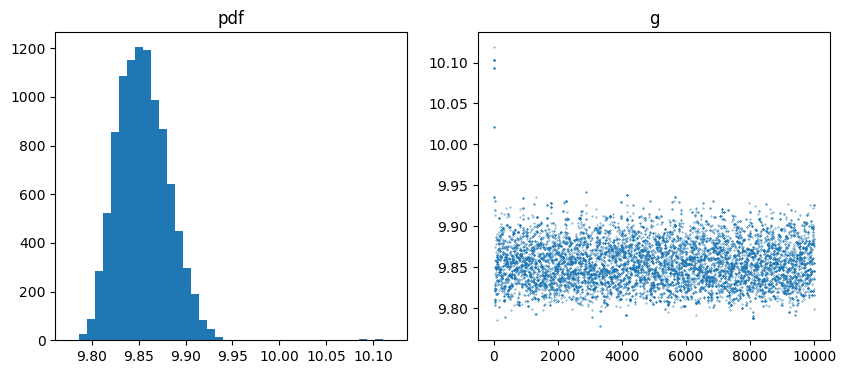

5234 / 10000 of the sampled particles were accepted (52.0%)
        
The expectation estimation is of 9.855134090860705


In [6]:
@everywhere measurements, measurements_mask = load_experiments()
@everywhere n_measurements = size(measurements)[1]
@everywhere max_intersects = size(measurements)[2]

@everywhere prior = Uniform(8,11)

@everywhere Θ₀ = [5*pi/180, 0]
@everywhere function dΘ(g)
    Θ -> [Θ[2], -g*sin(Θ[1])/8]
end

@everywhere loglikelihood = (k, n, g) ->
    let
        Gg = rk4s(dΘ(g), Θ₀, [0; measurements[k,1:n][measurements_mask[k,1:n] .!= 0]], 0.01) 
        b = log.(abs.(0.01 ./ (0.01 + Gg[2:end,1]))).^2
        sum(b)/0.5
    end;

out = GaussianMetropolisHastings(10000, prior, g -> loglikelihood(1, 11, g[1]), 0.05)
plotMCMC(out)

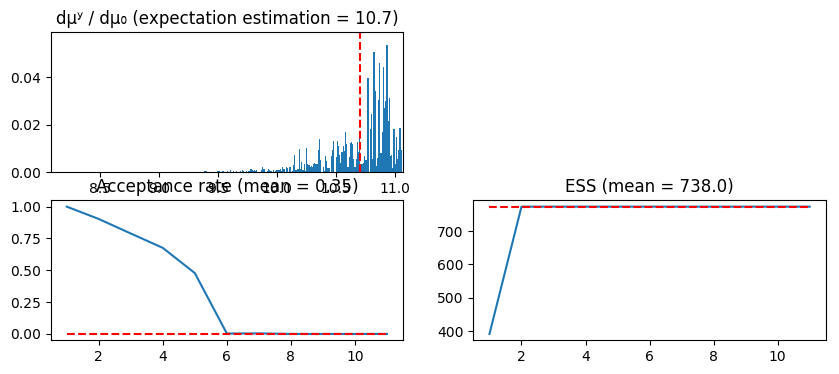

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fd7bc23f7d0>

In [42]:
# function SequentialMonteCarlo(X₀, p, γ; μ=0.1)
# @everywhere loglikelihood = (k, n, g) ->

srand(42)


function SequentialMonteCarlo(X₀, p, lhood; μ=0.1)
    # initialization
    N,d = size(X₀)
    w = MvNormal(μ^2 * eye(d))

    X = SharedArray{Float64}(X₀)
    dX = zeros(X₀)
    
    W = ones(N)/N
    Wₙ = SharedArray{Float64}(N)
    
    acceptance_rate = ones(p) ./ N
    ess = zeros(p)
    
    S = 1
    
    # initialize
    @sync @parallel for i=1:N
        Wₙ[i] = lhood(1, X[i,:])
    end
    
    Z = vecdot(W, Wₙ)
    W = W.*Wₙ / vecdot(W, Wₙ)

    for n = 1:p
        # update
        dX = rand(w, N)'
        acceptance_rate[n] *= @sync @parallel (+) for i=1:N
            xₙ = X[i,:] + dX[i,:]
            wₙ = lhood(n, xₙ)

            accepted = 0
            if rand() < min(1, wₙ / W[i])
                Wₙ[i] = Wₙ[i]*wₙ
                X[i,:] = xₙ
                accepted = 1
            end
            accepted
        end
        # normalize weights
        W = Wₙ / sum(Wₙ)

        # resample
        ess[n] = 1 / vecdot(W,W)
        if ess[n] < N/2            
            perm = rand(Categorical(W), N)
            X = X[perm, :]
            Wₙ = Wₙ[perm]
            W = ones(N)/N
        end
    end
    
    W,X,acceptance_rate,ess
end

N = 1000
X₀ = reshape(rand(prior, N), N, 1)

outs = SequentialMonteCarlo(X₀, 11, (n, g) -> exp(-loglikelihood(1, n, g[1])), μ=0.05)
plotSMC(outs)